# Deep learning solution method with all-in-one expectation operator for yaml models

## Introduction

The following code is a complet solution to solving economic models in a ".yaml" format thanks to machine learning. When such a problem is solved through a time iteration methode, the algorithm recalculates all states and controls at each iteration, which takes a substancial amount of time and calculation power.
The idea here is that a well trained neural network can replace the equations that link all theses variables, thus making the calculation of controls from states much quicker. In particular, simulation demands much less calculation power once the neural network is trained. This network, associated with steady-state variables basically replaces the full model.


## Hypothesis

In order for this code to work, the ".yaml" model must be built as follows :

- m represents the shocks of the exogenous variables.
- s represents the states for endogenous $\textbf{and}$exogenous variables (the exogenous variables must be followed by the endogenous variables).
- x represents the control variables. 
- In the parameter list, the standard deviations of the shocks are in the last positions and in the same order as the shocks in m.
- The parameter list exported form the yaml model is ordered as follows: [parameters of endogenous variables, initial values of endogenous variables, parameters of exogenous variables, initial values of exogenous variables, shocks of exogenous variables].

# Model importation 

In [4]:
from dolo import *
import tensorflow as tf
import numpy as np
from math import sqrt, exp, log
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime

# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

We start by importing the model we wish to solve with our machine learning algorithm. For this, we must define manually our "transition" and "arbitrage" functions with a simple Copy/Paste of "source". Idealy, we should find a way to make this automatic but for now it must be done by hand.

The transition function gives us the states at time $t+1$ knowing the the shocks at time $t+1$ as well as the states, the controls and the shocks at time $t$.

The arbitrage function gives us the residuals from the model. Theses residuals come from the first order Euler equations. The goal will be to minimize them, but we will come back to this later on. 

In [6]:
model = yaml_import('rbc.yaml')

In [7]:
#from dolo.compiler.factories import get_factory
#fac = get_factory(model, 'transition')
#import dolang
#transition = dolang.function_compiler.compile_factory(fac)
#source = dolang.function_compiler.to_source(transition)
#print( source )

def transition(m, s, x, M, p):
    e_z_m1_ = m[0]
    z_m1_ = s[0]
    k_m1_ = s[1]
    n_m1_ = x[0]
    i_m1_ = x[1]
    e_z__0_ = M[0]
    beta_ = p[0]
    sigma_ = p[1]
    eta_ = p[2]
    chi_ = p[3]
    delta_ = p[4]
    alpha_ = p[5]
    rho_ = p[6]
    zbar_ = p[7]
    sig_z_ = p[8]
    y_m1_ = ((tf.exp(z_m1_)) * ((k_m1_) ** (alpha_))) * ((n_m1_) ** ((1.0) - (alpha_)))       # ajout de tf.
    c_m1_ = (y_m1_) - (i_m1_)
    rk_m1_ = ((alpha_) * (y_m1_)) / (k_m1_)
    w_m1_ = (((1.0) - (alpha_)) * (y_m1_)) / (n_m1_)
    z__0_ = (rho_) * (z_m1_) + e_z__0_
    k__0_ = ((1.0) - (delta_)) * (k_m1_) + i_m1_
    
    return (z__0_,k__0_)

In [8]:
#from dolo.compiler.factories import get_factory
#fac = get_factory(model, 'arbitrage')             # fac is a FlatFunctionFactory types
#import dolang
#arbitrage = dolang.function_compiler.compile_factory(fac)         # Les deux équations d'abitrage
#source = dolang.function_compiler.to_source(arbitrage)
#print( source )

def arbitrage(m, s, x, M, S, X, p):
    e_z__0_ = m[0]
    z__0_ = s[0]
    k__0_ = s[1]
    n__0_ = x[0]
    i__0_ = x[1]
    e_z__1_ = M[0]
    z__1_ = S[0]
    k__1_ = S[1]
    n__1_ = X[0]
    i__1_ = X[1]
    beta_ = p[0]
    sigma_ = p[1]
    eta_ = p[2]
    chi_ = p[3]
    delta_ = p[4]
    alpha_ = p[5]
    rho_ = p[6]
    zbar_ = p[7]
    sig_z_ = p[8]
    y__0_ = ((tf.exp(z__0_)) * ((k__0_) ** (alpha_))) * ((n__0_) ** ((1.0) - (alpha_)))          # Ajour de tf.
    y__1_ = ((tf.exp(z__1_)) * ((k__1_) ** (alpha_))) * ((n__1_) ** ((1.0) - (alpha_)))
    c__0_ = (y__0_) - (i__0_)
    c__1_ = (y__1_) - (i__1_)
    rk__0_ = ((alpha_) * (y__0_)) / (k__0_)
    rk__1_ = ((alpha_) * (y__1_)) / (k__1_)
    w__0_ = (((1.0) - (alpha_)) * (y__0_)) / (n__0_)
    w__1_ = (((1.0) - (alpha_)) * (y__1_)) / (n__1_)
    out__0_ = (((chi_) * ((n__0_) ** (eta_))) * ((c__0_) ** (sigma_))) - (w__0_)
    out__1_ = (1.0) - (((beta_) * (((c__0_) / (c__1_)) ** (sigma_))) * ((1.0) - (delta_) + rk__1_))

    # if c__0_.numpy().any() > y__0_.numpy().any() or c__1_.numpy().any() > y__1_.numpy().any() :
    #     print('Il éxiste c > y problème')
    
    # if (c__0_.numpy().any()/y__0_.numpy().any()) == 0 or (c__1_.numpy().any()/y__1_.numpy().any()) == 0 : 
    #     print("La part d'output consommée est nulle")

    return (out__0_,out__1_)

 We then import all the parameters and steady-state conditions via "calibration". In particular, we create 3 lists representing shocks, states and controls at the steady-state as well as the list parameters that must be ordered as explained in the hypothesis section.

In [9]:
calibration = model.calibration

m0 = calibration['exogenous']
s0 = calibration['states']
x0 = calibration['controls']

parameters = calibration['parameters']

Finally, we import the states domains in 'list_domain'. We also import the name of the state variables in 'list_keys'.

In [14]:
domain = model.domain

# On transforme le dictionnaire en liste une liste de domaines et une liste avec les noms des états
list_domain=[]
list_keys=[]
for clef,valeur in domain.items():
    list_domain.append(valeur)
    list_keys.append(clef)

# Neural network construction

We try to solve our problem using one neural network.
We look for a decision rule 

$$
\begin{equation*}
\left( 
\begin{matrix}
control_1 \\ 
. \\
. \\
. \\
control_K%
\end{matrix}%
\right) =\varphi (s;\theta ),
\end{equation*}
$$

where $s=(state_1,...,state_N)$ is the N-dimensional state space, and $\varphi$ is a function to be determined. It is reminded that states must respect the order given in the hypothesis section.

In [58]:
layers = [
    tf.keras.layers.Dense(32, activation='sigmoid', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

We define our decision rule as explained above. Here, the decision rule takes a tensor vector of states and gives us a tuple of controls in tensor formats. It is important to understand that the states (and thus the controls) can themselves be vectors.

In [59]:
def dr(state: Vector):            # dr = decision rule   

    # We normalize state variables between -1 and 1, taking into account the hypothesis above.

    a = [variable for variable in state]

    for i in range(len(m0)):      # Exogenous states whose evolution is governed by shocks
        a[i] = a[i]/(parameters[-(len(m0)-i)]/(1-parameters[-(3*len(m0)-i)]**2)**0.5)/2     

    for i in range(len(s0)-len(m0)):      # Endogenous states
        a[len(m0)+i] = (a[i]-list_domain[i][0])/(list_domain[i][1]-list_domain[i][0])*2.0-1.0
    
    # we prepare input to the perceptron
    s = tf.concat([_e[:,None] for _e in a], axis=1)    # equivalent to np.column_stack

    x = perceptron(s) # n x len(state) matrix             # The deltas are hidden in this perceptron function
    
    # We apply exp because this ensures that controls are always positive
    x = tf.exp(x)
    
    return x

Now that our decision rule is defined, we plot the initial decisions for our controls depending on our states.

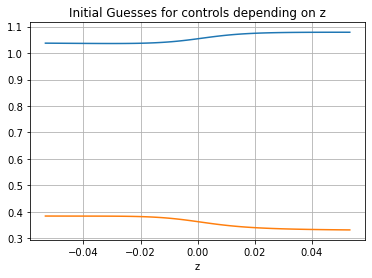

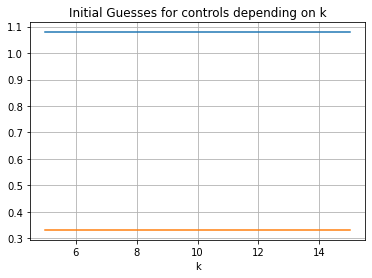

In [71]:
state_vec=[]
for i in range(len(s0)):
    variable_vec = np.linspace(list_domain[i][0], list_domain[i][1], 100)
    state_vec.append(variable_vec)

state_vec = tf.convert_to_tensor(state_vec)      # state_vec is a tensor containing an array of state vectors

mat=[]
for i in range(len(state_vec)):

    s = []
    if i!=0:
        for j in range(i):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))     # All state variables before the one considered are equal to their mean.
    
    s.append(state_vec[i])     # The i-th state variable is equal to its values in state_vec

    if i!=len(state_vec):
        for j in range(i+1,len(state_vec)):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))     # All state variables after the one considered are equal to their mean.
    
    x = dr(np.asarray(s))
    mat.append(x)

# here we plot the controls according to each state variable (the others being fixed and worth their averages)
# We thus get len(s0) different graphs 

for j in range(len(state_vec)):
    plt.figure()
    plt.plot(state_vec[j],mat[j])
    plt.xlabel(list_keys[j])
    plt.title('Initial Guesses for controls depending on '+list_keys[j])
    plt.grid()

To find the unknown decision function for our k controls, we define j residuals coming from the "arbitrage" equations. For this, we define :

$$
\begin{equation*}
\left( 
\begin{matrix}
R_1(m,s,x,M,S,X,p) \\ 
. \\
. \\
. \\
R_J(m,s,x,M,S,X,p) %
\end{matrix}%
\right) = arbitrage(m,s,x,M,S,X,p)
\end{equation*}
$$

where m, s and x are respectively shocks, states and controls at time $t$ and M, S and X at time $t+1$. the model parameters are contained in variable p. This means that the calculation of theses residuals depends on variables at times $t$ and $t+1$.

Because we do not actually needm and we can have x,M,S and X simply by knowing s through our decision rule and our transition function, we will rewright $R_j(m,s,x,M,S,X,p) = R_j(s,\epsilon')$ where $\epsilon'$ is M.

In [38]:
def Residuals(shocks: Vector, state: Vector):

    # all inputs are expected to have the same size n
    size = tf.size(state[0])

    # Controls at t 
    x = dr(state)
    
    i = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    n = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for j in range(size):
        i = i.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(0)])
        n = n.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(1)])
    i = i.stack()
    n = n.stack()
    control = (i,n)

    # State at t+1
    State = transition(tf.convert_to_tensor([0]), state, control, shocks, parameters)        # Je défini le choc à t de manière arbitraire à 0 car il n'est pas utile ici

    # Controls at t+1
    X = dr(State)

    I = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    N = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for j in range(size):
        I = I.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(0)])
        N = N.write(j,x[tf.convert_to_tensor(j)][tf.convert_to_tensor(1)])
    I = I.stack()
    N = N.stack()
    Control = (I,N)
    
    # Residuals, vector of size depending on the arbitrage function used in the model
    R = arbitrage(tf.convert_to_tensor([0]), state, control, shocks, State, Control, parameters)

    return R

## The expected squared sum of residuals

We construct the objective function for minimization as the squared sum of J residuals $(R_1,...,R_J)$ in the j model's equations on a given N-dimensional domain $s=(state_1,...,state_N)$: 

$$
\begin{equation*}
\Xi (\theta )=E_{s}\left[ \sum_{j=1}^{J} \left( v_jE_{\epsilon }\left[ R_j(s,\epsilon')\ \right] \right) ^{2}\right] ,
\end{equation*}
$$

where $v_j$ is the exogenous relative weight of the j-th residuals in the
objective function.

## All-in-one expectation function

in order to group all expetation operators we apply the following technique. We replace $\left( E_{\epsilon }\left[  R_j(s,\epsilon')\right] \right) ^{2}$ by the product of two residuals constructed
by using two uncorrelated random draws $\epsilon'_{1}$ and $\epsilon'_{2}$,
and therefore, we can pull the expectation out of squares 


$$
\begin{equation*}
E_{\epsilon _{1}}\left[ R_j(s,\epsilon'_1)\right]
E_{\epsilon _{2}}\left[  R_j(s,\epsilon'_2)\right]
=E_{\epsilon _{1},\epsilon _{2}}\left[ R_j(s,\epsilon'_1)R_j(s,\epsilon'_2) \right]. 
\end{equation*}
$$

With that result, we can re-write the objective function as just one
expectation operator: 

$$
\begin{equation*}
\Xi (\theta )=E_{s,\epsilon _{1},\epsilon _{2}}\left[ \underset{\xi (\omega;\theta )}{\underbrace{ \sum_{j=1}^{J} v_jR_{j}\left( s,\epsilon'_{1}\right) R_{j}\left(s,\epsilon' _{2}\right)}}\right] \equiv E_{\omega }\left[ \xi
(\omega ;\theta )\right],
\end{equation*}
$$

where $\omega =(s,\epsilon' _{1},\epsilon' _{2})$. Therefore, we wrote the
objective function of the deep learning method as a single expectation
operator $E_{\omega }\left[ \xi (\omega ;\theta )\right] $ of a function $%
\xi (\omega ;\theta )$ that depends on a vector-valued random variable $%
\omega $. We approximate $\Xi (\theta )$ by using Monte Carlo simulation:

$$
\begin{equation*}
\Xi (\theta )\approx \Xi ^{n}(\theta )=\frac{1}{n}\sum_{i=1}^{n}\xi (\omega
_{i};\theta ),
\end{equation*}
$$

i.e., we draw $n$ random draws of $\omega =(s,\epsilon' _{1},\epsilon' _{2})$
and compute the average of the objective function

In [72]:
def Ξ(n): # objective function for DL training
    
    state = []

    for i in range(len(m0)):      # Exogenous states whose evolution is governed by shocks
        variable = tf.random.normal(shape=(n,), stddev=(parameters[-(len(m0)-i)]/(1-parameters[-(3*len(m0)-i)]**2)**0.5))     #parameters[-(3*len(m0)-i)] is the parameter rho in z' = rho * z + choc
        state.append(variable)

    for i in range(len(s0)-len(m0)):      # Endogenous states
        variable = tf.random.uniform(shape=(n,), minval=list_domain[len(m0)+i][0], maxval=list_domain[len(m0)+i][1])
        state.append(variable)
    
    state = tuple(state)

    shocks_1 = []
    shocks_2 = []
    for i in range(len(m0)):
        shocks_1.append(tf.random.normal(shape=(n,), stddev=parameters[-(len(m0)-i)]))
        shocks_2.append(tf.random.normal(shape=(n,), stddev=parameters[-(len(m0)-i)]))
    
    # residuals for n random grid points under 2 realizations of shocks
    R_e1 = Residuals(shocks_1, state)
    R_e2 = Residuals(shocks_2, state)

    # construct all-in-one expectation operator, here v = (1,...,1)
    R_squared = 0         
    for i in range(len(R_e1)):
        R_squared = R_squared + R_e1[i]*R_e2[i]
    
    
    # compute average across n random draws
    return tf.reduce_mean(R_squared)

In [73]:
n = 128
v = Ξ(n)
v.numpy()

442507.7

# Model Training

In this part, we train the model in graph mode. This is why, in previous code, we never used numpy, which seems to work only in eager mode.

Once the model is trained, we plot Ξ(n) step by step as well as the new trained decision rules for our neural network. In this code, it is difficult to plot easily understandable graphs as we do not have acces to the names of our controls. For this reason, I suggest that you create your plot the graphs you want by hand, using the output of my 'simulation' function. This plot can thus depend on the model, where as mine works for any model but is not of great quality.

In [41]:
θ = perceptron.trainable_variables
#print( str(θ)[:1000] ) # we truncate output

In [42]:
from tensorflow.keras.optimizers import Adam, SGD     # Choice of otpimizer

optimizer = Adam()
# optimizer = SGD(λ=0.1) # SGD can be used in place of Adam

In [43]:
@tf.function              # Each training step is in graph mode
def training_step():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ)
    optimizer.apply_gradients(zip(grads,θ))

    return xx

In [44]:
def train_me(K):

    vals = []
    for k in tqdm(tf.range(K)):
        val = training_step()
        vals.append(val.numpy())
        vals.append(val.numpy())
        
    return vals

In [52]:
results = train_me(20000)

100%|██████████| 20000/20000 [16:25<00:00, 20.30it/s]


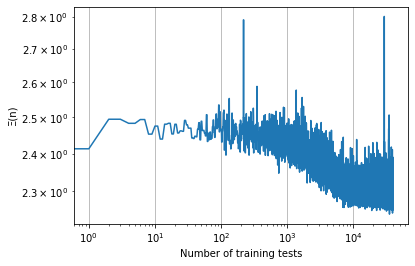

In [53]:
plt.plot(np.sqrt(results))
plt.xlabel('Number of training tests')
plt.ylabel('Ξ(n)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

The training is long (about 1 minute per 1000 training steps) and Ξ(n) goes down to $10^0$ at most. Theses results arent't good enough but I was unable to find why. 

I have identified a few possibilities though :

- There are a lot of useless calculations in this notebook, but they are necessary to keep it as automatic as possible. For instance, the 'transition' and 'arbitrage' functions contain useless operations.
- Many lines of code are here to keep data in the wished formats. Theses operations can surely be optimized.
- I forced myself to stay in graph mode, which differs from the notebooks specific to the RBC model and the Consumption Saving model. In theses notebooks, numpy didn't seem to be a problem, but I have been unable to identify why it is in this notebook. My intuition says it could be because of the new arbitrage and transition functions.

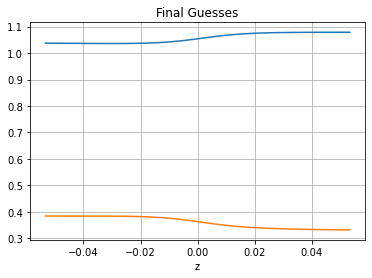

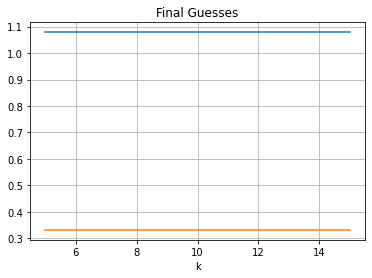

In [90]:
state_vec=[]
for i in range(len(s0)):
    variable_vec = np.linspace(list_domain[i][0], list_domain[i][1], 100)
    state_vec.append(variable_vec)

state_vec = np.asarray(state_vec)

mat=[]
for i in range(len(state_vec)):

    s = []
    if i!=0:
        for j in range(i):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))      
    
    s.append(state_vec[i])    

    if i!=len(state_vec):
        for j in range(i+1,len(state_vec)):
            s.append(((list_domain[j][1]-list_domain[j][0])/2)*(state_vec[j]/state_vec[j]))     
    
    x = dr(np.asarray(s))
    mat.append(x)

for j in range(len(state_vec)):
    plt.figure()
    plt.plot(state_vec[j],mat[j])
    plt.xlabel(list_keys[j])
    plt.title("Final Guesses")
    plt.grid()

# Simulation

# Stochastic simulations

Our goal is to write a function that simulates our model N times for a certain number of time periods T.

In [74]:
def simulate(model, dr, N, T):

    calibration = model.calibration
    m0 = calibration['exogenous']
    s0 = calibration['states']
    x0 = calibration['controls']
    parameters = calibration['parameters']

    simulations = []

    for n in range(N) :

        result = []
        s=[]
        for variable in s0:
            s.append([variable])            # Format for dr function
        m = m0

        for t in range(T) :

            control = dr(s)             # dr needs a list of list of variables
            x = []
            for i in range(len(control[0])):
                x.append([control[0][i].numpy()])

            result.append([[[m] for m in m],[a for a in s],x])

            for i in range(len(s)):        # Reformat for transition function
                s[i]=s[i][0]

            m = []
            for i in range(len(m0)):
                m.append(tf.random.normal(shape=(1,) , stddev=parameters[-(len(m0)-i)]).numpy())        # We define the shock for the next time period 
            
            state = transition(m,s,x,m,parameters)       # transition needs a simple list of variables
            
            s = []
            for variable in state:         # Reformat for dr function
                s.append(variable)
        
        simulations.append(result)
    simulations = np.asarray(simulations)

    return simulations                    # N x T x (len(m0)+len(s0)+len(x0)) matrix

In [87]:
sim = simulate(model,dr,200,100)

    Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


    Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


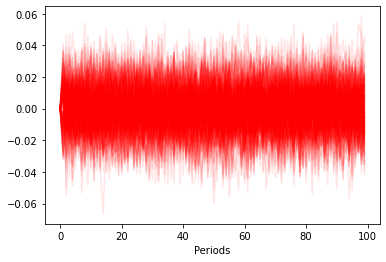

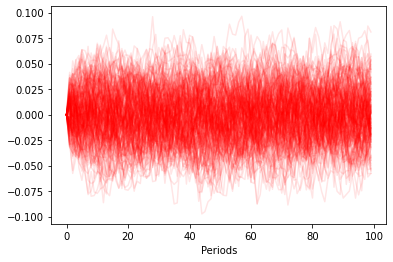

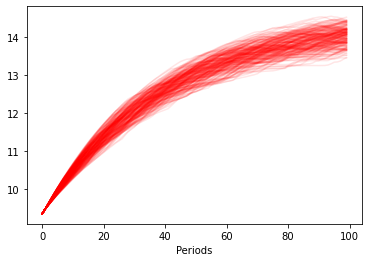

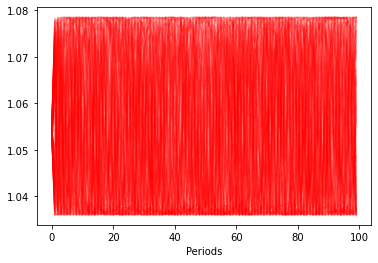

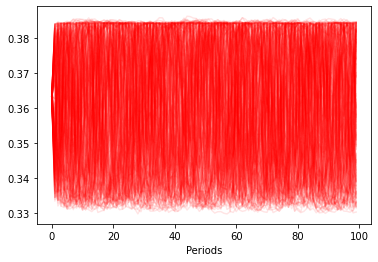

In [89]:
mat = []

for i in range(len(sim)):
    mat.append([])

for simulation in range(len(sim)):
    for j in range(len(sim[0][0])):             #[m,s,x]
        mat[simulation].append([])
    for k in range(len(sim[0][0])):
        for n in range(len(sim[0][0][k])):
            mat[simulation][k].append([])

for i in range(len(sim)):
    for t in range(len(sim[i])):
        for v in range(len(sim[i][t])):
            for l in range(len(sim[i][t][v])):
                mat[i][v][l].append(sim[i][t][v][l][0])

for i in range(len(sim)):
    for v in range(len(mat[i])):
            for l in range(len(mat[i][v])):
                a = 10*v +l
                plt.figure(a)
                plt.xlabel('Periods')
                plt.plot(mat[i][v][l], color='red', alpha=0.1)

# plt.subplot(331)
# plt.title('Shocks')
# plt.subplot(332)
# plt.title('Technological progress')
# plt.subplot(333)                                  # This is specific to the RBC model but I let it here to be adapted to another model.
# plt.title('Capital')
# plt.subplot(334)
# plt.title('Investment')
# plt.subplot(335)
# plt.title('Labor')